In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('dataset music/data_playcount.csv')

users = df['id_user'].values
tracks = df['id_track'].values
initial_playcounts = df['count'].values
playcounts = 1 + (initial_playcounts - 1) * (5 - 1) / (50 - 1)
print(playcounts)


uniques = [np.unique(users).shape[0], np.unique(tracks).shape[0]]

print('number of unique users:', uniques[0])
print('number of unique tracks:', uniques[1])
print('number of playcounts:', users.shape[0])
print('total number of cells:', uniques[0] * uniques[1])
print('Ratio of entries filled:', users.shape[0]/(uniques[0] * uniques[1]))


[5.         5.         4.10204082 ... 1.         1.         1.        ]
number of unique users: 11
number of unique tracks: 67241
number of playcounts: 125763
total number of cells: 739651
Ratio of entries filled: 0.17003018991389182


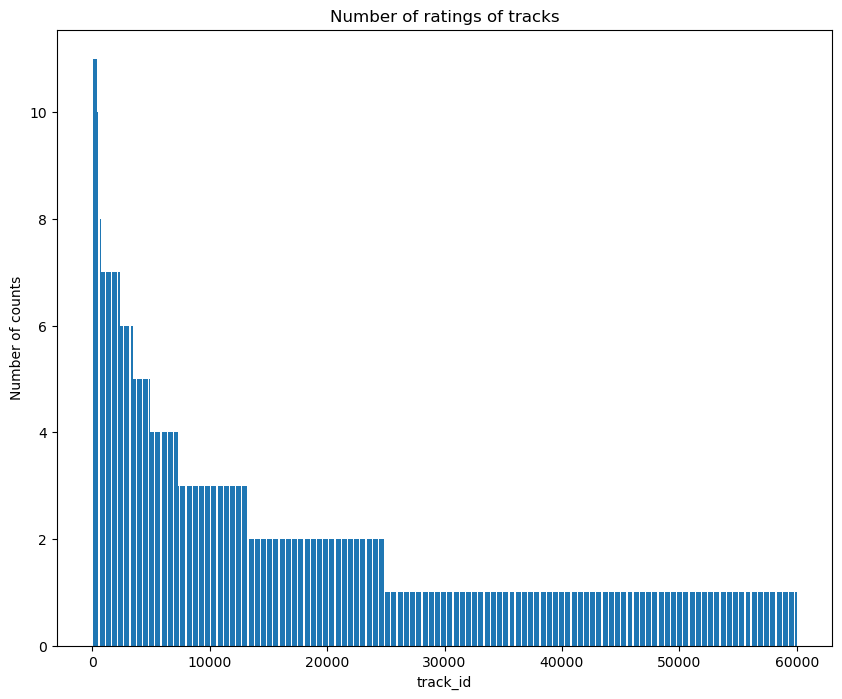

In [2]:
track_uniques = np.unique(tracks)

track_occurances = []
for track in track_uniques:
    occ = np.count_nonzero(tracks == track)
    track_occurances.append(occ)
track_occurances = np.array(track_occurances)

sort_indices = np.argsort(track_occurances) 

track_uniques_occ_sorted = track_uniques[sort_indices]
track_uniques_occ_sorted = track_uniques_occ_sorted[::-1]
track_uniques_occ_sorted = np.array(track_uniques_occ_sorted)

track_occurances_sorted = track_occurances[sort_indices]
track_occurances_sorted = track_occurances_sorted[::-1]

plt.figure(figsize=(10,8))
plt.bar(range(len(track_occurances_sorted[0:60000])), track_occurances_sorted[:60000])
plt.title('Number of ratings of tracks')
plt.xlabel('track_id')
plt.ylabel('Number of counts')
plt.show()

In [3]:
M = np.zeros((uniques[0], uniques[1]))
mask = np.zeros(M.shape)
for u, t, c in zip(users, tracks, playcounts):
    M[u, np.where(track_uniques_occ_sorted == t)[0][0]]= c
    mask[u, np.where(track_uniques_occ_sorted == t)[0][0]]= 1.
     
print(np.sum(mask))

125763.0


In [4]:
test_count = 60000
_is = np.random.randint(0, len(users), test_count)
 
test_mask = np.zeros(M.shape)
for i in _is:
    _user = users[i]
    _track = np.where(track_uniques_occ_sorted == tracks[i])[0][0]
    test_mask[_user, _track] = 1
     
print(np.sum(test_mask))

47703.0


In [5]:
cutoff = 30000
M = tf.constant(M[:, :cutoff], dtype=tf.float32)
mask = tf.cast(mask[:, :cutoff], dtype=tf.float32)  
test_mask = tf.cast(test_mask[:, :cutoff], dtype=tf.float32)
train_mask = mask - test_mask

print('Number of testing:', tf.reduce_sum(test_mask))
print('Number of training:', tf.reduce_sum(train_mask))


Number of testing: tf.Tensor(33446.0, shape=(), dtype=float32)
Number of training: tf.Tensor(55076.0, shape=(), dtype=float32)


In [6]:
def early_stopping(losses, patience = 5):
     
    if len(losses) <= patience + 1:
        return False
     
    avg_loss = np.mean(losses[-1 - patience:-1])
     
    if avg_loss - losses[-1] < 0.01*avg_loss:
        return True
     
    return False

In [7]:
def train(k):
    U_d = tf.Variable(tf.random.normal((11, k)))
    V_d = tf.Variable(tf.random.normal((k, cutoff)))
    
    train_norm = tf.reduce_sum(train_mask)
    test_norm = tf.reduce_sum(test_mask)
    
    adam_opt = tf.keras.optimizers.Adam()
    from datetime import datetime
    lr = 0.001
    ep = 0
    start_time = datetime.now()
    train_losses = []
    test_losses = []
    
    while True:
        with tf.GradientTape() as tape:
            M_app = U_d @ V_d
            pred_errors_squared = tf.square(M - M_app)
            train_loss = tf.reduce_sum((train_mask * pred_errors_squared)/train_norm)
        test_loss = tf.reduce_sum((test_mask * pred_errors_squared) / test_norm)
    
        if ep%100 == 0:
            print(datetime.now() - start_time, train_loss, test_loss, ep)
            train_losses.append(train_loss.numpy())
            test_losses.append(test_loss.numpy())
        if early_stopping(train_losses):
            break
            
        grads = tape.gradient(train_loss, [U_d, V_d])
        adam_opt.apply_gradients(zip(grads, [U_d, V_d]))
    
        ep += 1

    return train_losses, test_losses, U_d, V_d
    


In [8]:
train_losses, test_losses, U_d, V_d = train(2)

0:00:00.078368 tf.Tensor(3.1039085, shape=(), dtype=float32) tf.Tensor(3.054923, shape=(), dtype=float32) 0
0:00:01.769954 tf.Tensor(2.4915566, shape=(), dtype=float32) tf.Tensor(2.6770768, shape=(), dtype=float32) 100
0:00:03.631934 tf.Tensor(2.0688977, shape=(), dtype=float32) tf.Tensor(2.4027464, shape=(), dtype=float32) 200
0:00:05.548849 tf.Tensor(1.7607105, shape=(), dtype=float32) tf.Tensor(2.1837993, shape=(), dtype=float32) 300
0:00:07.410141 tf.Tensor(1.5228808, shape=(), dtype=float32) tf.Tensor(1.9980804, shape=(), dtype=float32) 400
0:00:09.288688 tf.Tensor(1.3287314, shape=(), dtype=float32) tf.Tensor(1.8337886, shape=(), dtype=float32) 500
0:00:11.159853 tf.Tensor(1.1624862, shape=(), dtype=float32) tf.Tensor(1.6847217, shape=(), dtype=float32) 600
0:00:13.039655 tf.Tensor(1.0152793, shape=(), dtype=float32) tf.Tensor(1.5465461, shape=(), dtype=float32) 700
0:00:14.941166 tf.Tensor(0.8822137, shape=(), dtype=float32) tf.Tensor(1.4180442, shape=(), dtype=float32) 800
0:00

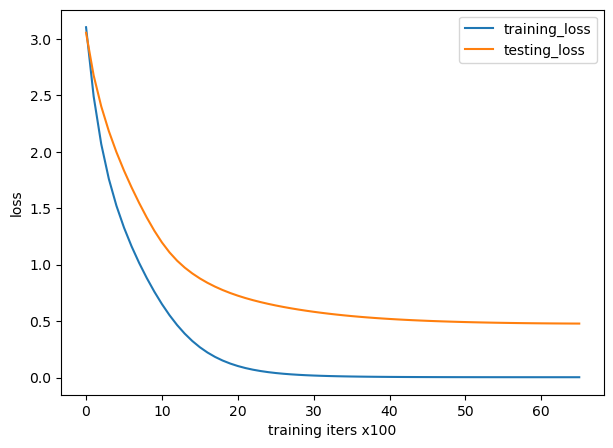

In [9]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label = 'training_loss')
plt.plot(test_losses, label = 'testing_loss')
plt.xlabel('training iters x100')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
M_pred = tf.matmul(U_d, V_d)
M_pred


<tf.Tensor: shape=(11, 30000), dtype=float32, numpy=
array([[1.0319664 , 1.0165133 , 1.0128742 , ..., 0.10215798, 0.99990946,
        1.1566957 ],
       [1.0369676 , 1.0212023 , 1.0173721 , ..., 0.10306949, 1.005159  ,
        1.1631601 ],
       [1.0133533 , 0.9987078 , 0.9955207 , ..., 0.09938746, 0.98097503,
        1.1339194 ],
       ...,
       [0.9822273 , 0.98042744, 0.9863998 , ..., 0.07457817, 0.9297525 ,
        1.0542248 ],
       [0.9787522 , 0.9727431 , 0.9756127 , ..., 0.08171321, 0.9336356 ,
        1.0657526 ],
       [0.99306744, 0.98003685, 0.97787994, ..., 0.09507775, 0.9590881 ,
        1.1064355 ]], dtype=float32)>

In [11]:
users = pd.read_csv('dataset music/users.csv')
tracks = pd.read_csv('dataset music/tracks.csv')

In [12]:
def recommendation(user):
    # Tìm ID của user
    user_row = users[users['Username'] == user]['index']
    
    if user_row.empty:
        print("User không tồn tại!")
        return
    
    user_id = user_row.values[0]  # Lấy giá trị đầu tiên
    
    # Lấy 10 bài hát được đề xuất
    top_10_recommendations = np.argsort(-M_pred, axis=1)[:, :10]
    tracks_id = top_10_recommendations[user_id]

    print(f"Top 10 gợi ý cho user {user}:")
    for track_id in tracks_id:
        track_row = tracks[tracks['index'] == track_id]['Track']
        
        if not track_row.empty:
            print(track_row.values[0])
        else:
            print(f"Không tìm thấy bài hát có index {track_id}")


In [13]:
recommendation('Babs_05')

Top 10 gợi ý cho user Babs_05:
CHKDSK.EXE
Dizajnerica Laura
Aži Dahāka
The Genesis
Cross Off
Sheep Of The Gazpacho's Bane
We Are the People
Roped In
Episodio 1 - Il quaderno
I Heard It Through the Grapevine
